## Teak Plantation Volume Estimation with Random Forest and XGBoost

### Import Libraries

In [1]:
import pyodbc

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Database Connection and Display the relevant tables in the database

In [2]:
db_path = r"C:\Users\GILBERT FG\Desktop\Readings\PSP_database.accdb"

conn = pyodbc.connect(
    r"DRIVER={Microsoft Access Driver (*.mdb, *.accdb)};"
    rf'DBQ={db_path};'
)

cursor = conn.cursor()

for table in cursor.tables(tableType='TABLE'):
    print(table.table_name)


Block register
Plot monitoring history
Plot-block relation
PSPs
Slope correction factors
Thinning history
TreeData


#### Querying the TreeData table

In [3]:
query = "SELECT * FROM TreeData WHERE AreaType='Teak'"

df = pd.read_sql(query, conn)

C:\Users\GILBERT FG\AppData\Local\Temp\ipykernel_11072\3977747108.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


In [4]:
df.head()

,Plantations,AreaType,Monitoring year,Monitoring month,Monitoring day,PLOT,TREE NR,Tree SPECIES,Species scientific name,H (m),DBH (cm),Merchantable height (m),REMARKS,Incorrect DBH,Incorrect H,Incorrect H / DBH,Exclude,Justification for exclusion
0,Tain II,Teak,2018.0,1.0,13,1,71.0,Teak,Tectona grandis,7.25,12.0,None,Fire scars,False,False,None,False,None
1,Tain II,Teak,2018.0,1.0,13,1,76.0,Teak,Tectona grandis,8.25,12.0,None,Fire scars,False,False,None,False,None
2,Tain II,Teak,2018.0,1.0,13,1,68.0,Teak,Tectona grandis,7.00,11.8,None,Fire scars,False,False,None,False,None
3,Tain II,Teak,2018.0,1.0,13,1,53.0,Teak,Tectona grandis,7.25,11.5,None,Fire scars,False,False,None,False,None
4,Tain II,Teak,2018.0,1.0,13,1,58.0,Teak,Tectona grandis,7.00,10.5,None,Fire scars,False,False,None,False,None


#### Data Cleansing and Shaping

In [5]:
df = df.rename(columns={'Tree SPECIES': 'species', 'PLOT': 'plot_id', 'TREE NR': 'tree_id', 'H (m)': 'height_m', 'DBH (cm)': 'dbh_cm'})

In [6]:
df.head()

,Plantations,AreaType,Monitoring year,Monitoring month,Monitoring day,plot_id,tree_id,species,Species scientific name,height_m,dbh_cm,Merchantable height (m),REMARKS,Incorrect DBH,Incorrect H,Incorrect H / DBH,Exclude,Justification for exclusion
0,Tain II,Teak,2018.0,1.0,13,1,71.0,Teak,Tectona grandis,7.25,12.0,None,Fire scars,False,False,None,False,None
1,Tain II,Teak,2018.0,1.0,13,1,76.0,Teak,Tectona grandis,8.25,12.0,None,Fire scars,False,False,None,False,None
2,Tain II,Teak,2018.0,1.0,13,1,68.0,Teak,Tectona grandis,7.00,11.8,None,Fire scars,False,False,None,False,None
3,Tain II,Teak,2018.0,1.0,13,1,53.0,Teak,Tectona grandis,7.25,11.5,None,Fire scars,False,False,None,False,None
4,Tain II,Teak,2018.0,1.0,13,1,58.0,Teak,Tectona grandis,7.00,10.5,None,Fire scars,False,False,None,False,None


In [7]:
df.shape

(354797, 18)

In [8]:
blk_query = r"SELECT * FROM [Block register]"

block_df = pd.read_sql(blk_query, conn)

C:\Users\GILBERT FG\AppData\Local\Temp\ipykernel_11072\2663950081.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  block_df = pd.read_sql(blk_query, conn)


In [9]:
block_df.head()

,PLANTATION,BLOCK,STATUS,ROTATION,OWNERSHIP,RESERVE,YEAR PLANTED,BLOCK AREA (ha),PRODUCTIVE,UNPRODUCTIVE,TEAK,NATURAL INDIGENOUS,PLANTED INDIGENOUS,GMELINA,OPEN LAND,ROCK,REMARK
0,Akumadan,2A,PLANTED,1,FORM GHANA,ASUBIMA,2008,77.853644,77.853644,0.00,77.853644,NaN,NaN,NaN,NaN,NaN,None
1,Akumadan,2B,PLANTED,1,FORM GHANA,ASUBIMA,2010,4.523337,4.523337,NaN,4.523337,NaN,NaN,NaN,NaN,NaN,None
2,Akumadan,4,PLANTED,1,FORM GHANA,ASUBIMA,2009,42.605816,42.605816,0.00,42.605816,NaN,NaN,NaN,NaN,NaN,None
3,Akumadan,5,PLANTED,1,FORM GHANA,ASUBIMA,2009,63.458447,62.918447,0.54,62.918447,NaN,NaN,NaN,NaN,0.54,None
4,Akumadan,6,PLANTED,1,FORM GHANA,ASUBIMA,2009,78.999204,78.999204,0.00,78.999204,NaN,NaN,NaN,NaN,NaN,None


In [10]:
block_df = block_df[['PLANTATION', 'BLOCK', 'YEAR PLANTED', 'PRODUCTIVE', 'TEAK']]

In [11]:
block_df = block_df.rename(columns={'PLANTATION': 'Plantations', 'BLOCK': 'Block', 'YEAR PLANTED': 'year_planted', 'PRODUCTIVE': 'productive_area', 'TEAK': 'with_teak_ha'})

In [12]:
block_df.head()

,Plantations,Block,year_planted,productive_area,with_teak_ha
0,Akumadan,2A,2008,77.853644,77.853644
1,Akumadan,2B,2010,4.523337,4.523337
2,Akumadan,4,2009,42.605816,42.605816
3,Akumadan,5,2009,62.918447,62.918447
4,Akumadan,6,2009,78.999204,78.999204


In [13]:
plt_blk_relation_query = r"SELECT * FROM [Plot-block relation] WHERE AreaType = 'Teak'"

plt_blk_df = pd.read_sql(plt_blk_relation_query, conn)

C:\Users\GILBERT FG\AppData\Local\Temp\ipykernel_11072\3021702405.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  plt_blk_df = pd.read_sql(plt_blk_relation_query, conn)


In [14]:
plt_blk_df.head()

,RelationID,Plantations,Plot no,AreaType,Deviating plant year,Block,Start date,End date
0,74,Tain II,1370,Teak,NaN,PF80,2020-05-01,9999-12-31 00:00:00
1,76,Tain II,1372,Teak,NaN,C17,2020-05-01,9999-12-31 00:00:00
2,77,Tain II,1366,Teak,NaN,C17,2020-05-01,9999-12-31 00:00:00
3,78,Tain II,1363,Teak,NaN,C17,2020-05-01,9999-12-31 00:00:00
4,79,Tain II,1374,Teak,NaN,C17,2020-05-01,9999-12-31 00:00:00


In [15]:
plt_blk_df = plt_blk_df[['Plantations', 'Plot no', 'AreaType', 'Block']]

In [16]:
plt_blk_df.head()

,Plantations,Plot no,AreaType,Block
0,Tain II,1370,Teak,PF80
1,Tain II,1372,Teak,C17
2,Tain II,1366,Teak,C17
3,Tain II,1363,Teak,C17
4,Tain II,1374,Teak,C17


In [17]:
merged_plt_blk = pd.merge(block_df, plt_blk_df, on=['Plantations', 'Block'])

In [18]:
merged_plt_blk.head()

,Plantations,Block,year_planted,productive_area,with_teak_ha,Plot no,AreaType
0,Akumadan,2A,2008,77.853644,77.853644,667,Teak
1,Akumadan,2A,2008,77.853644,77.853644,666,Teak
2,Akumadan,2A,2008,77.853644,77.853644,4,Teak
3,Akumadan,2A,2008,77.853644,77.853644,5,Teak
4,Akumadan,2A,2008,77.853644,77.853644,8,Teak


In [19]:
merged_plt_blk.shape

(1567, 7)

In [20]:
df.head()

,Plantations,AreaType,Monitoring year,Monitoring month,Monitoring day,plot_id,tree_id,species,Species scientific name,height_m,dbh_cm,Merchantable height (m),REMARKS,Incorrect DBH,Incorrect H,Incorrect H / DBH,Exclude,Justification for exclusion
0,Tain II,Teak,2018.0,1.0,13,1,71.0,Teak,Tectona grandis,7.25,12.0,None,Fire scars,False,False,None,False,None
1,Tain II,Teak,2018.0,1.0,13,1,76.0,Teak,Tectona grandis,8.25,12.0,None,Fire scars,False,False,None,False,None
2,Tain II,Teak,2018.0,1.0,13,1,68.0,Teak,Tectona grandis,7.00,11.8,None,Fire scars,False,False,None,False,None
3,Tain II,Teak,2018.0,1.0,13,1,53.0,Teak,Tectona grandis,7.25,11.5,None,Fire scars,False,False,None,False,None
4,Tain II,Teak,2018.0,1.0,13,1,58.0,Teak,Tectona grandis,7.00,10.5,None,Fire scars,False,False,None,False,None


In [21]:
df = df[['Plantations', 'AreaType', 'Monitoring year', 'plot_id', 'tree_id', 'species', 'height_m', 'dbh_cm', 'REMARKS']]

In [22]:
df.head()

,Plantations,AreaType,Monitoring year,plot_id,tree_id,species,height_m,dbh_cm,REMARKS
0,Tain II,Teak,2018.0,1,71.0,Teak,7.25,12.0,Fire scars
1,Tain II,Teak,2018.0,1,76.0,Teak,8.25,12.0,Fire scars
2,Tain II,Teak,2018.0,1,68.0,Teak,7.00,11.8,Fire scars
3,Tain II,Teak,2018.0,1,53.0,Teak,7.25,11.5,Fire scars
4,Tain II,Teak,2018.0,1,58.0,Teak,7.00,10.5,Fire scars


In [23]:
merged_plt_blk = merged_plt_blk.rename(columns={'Plot no': 'plot_id'})

In [24]:
merged_plt_blk.head()

,Plantations,Block,year_planted,productive_area,with_teak_ha,plot_id,AreaType
0,Akumadan,2A,2008,77.853644,77.853644,667,Teak
1,Akumadan,2A,2008,77.853644,77.853644,666,Teak
2,Akumadan,2A,2008,77.853644,77.853644,4,Teak
3,Akumadan,2A,2008,77.853644,77.853644,5,Teak
4,Akumadan,2A,2008,77.853644,77.853644,8,Teak


In [26]:
df = pd.merge(df, merged_plt_blk, on=['Plantations', 'plot_id', 'AreaType'])

In [27]:
df.head()

,Plantations,AreaType,Monitoring year,plot_id,tree_id,species,height_m,dbh_cm,REMARKS,Block,year_planted,productive_area,with_teak_ha
0,Tain II,Teak,2018.0,1,71.0,Teak,7.25,12.0,Fire scars,B39,2013,61.114539,61.114539
1,Tain II,Teak,2018.0,1,76.0,Teak,8.25,12.0,Fire scars,B39,2013,61.114539,61.114539
2,Tain II,Teak,2018.0,1,68.0,Teak,7.00,11.8,Fire scars,B39,2013,61.114539,61.114539
3,Tain II,Teak,2018.0,1,53.0,Teak,7.25,11.5,Fire scars,B39,2013,61.114539,61.114539
4,Tain II,Teak,2018.0,1,58.0,Teak,7.00,10.5,Fire scars,B39,2013,61.114539,61.114539


In [28]:
df.shape

(344012, 13)

In [29]:
df['age'] = df['Monitoring year'] - df['year_planted']

In [30]:
df.head()

,Plantations,AreaType,Monitoring year,plot_id,tree_id,species,height_m,dbh_cm,REMARKS,Block,year_planted,productive_area,with_teak_ha,age
0,Tain II,Teak,2018.0,1,71.0,Teak,7.25,12.0,Fire scars,B39,2013,61.114539,61.114539,5.0
1,Tain II,Teak,2018.0,1,76.0,Teak,8.25,12.0,Fire scars,B39,2013,61.114539,61.114539,5.0
2,Tain II,Teak,2018.0,1,68.0,Teak,7.00,11.8,Fire scars,B39,2013,61.114539,61.114539,5.0
3,Tain II,Teak,2018.0,1,53.0,Teak,7.25,11.5,Fire scars,B39,2013,61.114539,61.114539,5.0
4,Tain II,Teak,2018.0,1,58.0,Teak,7.00,10.5,Fire scars,B39,2013,61.114539,61.114539,5.0


In [31]:
df['species'].unique()

array(['Teak', 'York', None, 'onyono', 'Mahogany', 'Cassia', 'Albizia',
       'Awiemfosamina', 'Kyenkyen', 'Sofo', 'Onyina', 'Wawa',
       'Unknown indigenous', 'Asanfena', 'Hontan', 'Akuakuo-Ninsuo',
       'Okoro', 'Nyankyerene', 'Watapuo', 'Akonkodie', 'Mango',
       'kwakuanisuo', 'Hyedua', 'Nyamedua', 'kotrenfro', 'Ofram',
       'Konkroma', 'Cedrela', 'Khaya ivorensis', 'Albizia adianthifolia',
       'Kane', 'Wama', 'Wonton', 'Funtumia africana', 'Odum',
       'Trilepisium madagascariense', 'Tetrapleura tetraptera', 'Kusia',
       'Okure', 'Foto', 'Womba', 'Alstonia boonei',
       'Anacardium occidentale', 'Dead', 'Afzelia', 'Otie', 'coconisuol',
       'prekese', 'Kotreamfo', 'Acacia', 'Akye', 'Nofotene', 'Acasia',
       'Kigelia africana', 'Prekese', 'Kookonisuo', 'saiba', 'Pepea',
       '(Cog)Wabire', 'abiziar', 'Pampam', 'Sese', 'Sybie', 'Cola',
       'Palm tree', 'Saiba', 'Indigenous', 'indigenous'], dtype=object)

In [32]:
teak = 'Teak'

for i in df['species']:
    if i != teak:
        df = df[~((df['species'] == i))]

In [33]:
df['species'].unique()

array(['Teak', None], dtype=object)

In [34]:
df.shape

(342555, 14)

In [35]:
df['Plantations'].unique()

array(['Tain II', 'Akumadan'], dtype=object)

In [36]:
df.isna().sum()

Plantations             0
AreaType                0
Monitoring year         0
plot_id                 0
tree_id                 2
species                44
height_m               73
dbh_cm                219
REMARKS            220969
Block                   0
year_planted            0
productive_area         0
with_teak_ha           72
age                     0
dtype: int64

In [37]:
df = df.dropna(subset=['height_m', 'dbh_cm'])

In [38]:
df.isna().sum()

Plantations             0
AreaType                0
Monitoring year         0
plot_id                 0
tree_id                 0
species                42
height_m                0
dbh_cm                  0
REMARKS            220829
Block                   0
year_planted            0
productive_area         0
with_teak_ha           72
age                     0
dtype: int64

In [39]:
df.shape

(342332, 14)

In [40]:
df['REMARKS'].unique()

array(['Fire scars', None, 'Beetle infestation', 'Top broken', 'Coppice',
       'Broken top', 'Forked', 'Dead tree', 'Forked at 30 cm',
       'Fork at 2m', 'Nearly dead', '2 stems', 'Beside a termite mould',
       'leaves eaten by grasshoppers', 'Wildling',
       'Outside planting line - Wildling', 'marked',
       'bark damaged by termites', 'Dead tree - marked',
       'Has leaves to about 6m', 'dead tree, but resprouting',
       'Sapling - Wildling', 'Black ant attack from base to top',
       'dead tree, but coppicing', 'Old teak stand', 'Double stem',
       '3 stems', 'Dying', 'ceber', 'Main tree dead', 'Top dead',
       'Beaten-up', 'Forked at DBH, taken above', 'No leaves, but alive',
       'Diseased', 'top slashed', 'Teak dieback', 'Top dead - Wildling',
       'Beaten-up. Top slashed', 'Beaten-up. Top dead', 'Sunto', 'sunto',
       'Old teak - Coppice', 'Old teak - Teak dieback', 'Old teak',
       '2012 teak', '2012 teak, top slashed', 'Burnt - Coppice',
       'Burn

In [41]:
unwanted_list = ['Beetle infestation', 'Top broken', 'Coppice', 'Broken top', 'Forked', 'Dead tree', 'Forked at 30 cm', 'Fork at 2m', 'Nearly dead',
                  'Wildling', 'Outside planting line - Wildling', 'marked', 'Dead tree - mared', 'dead tree, but resprouting', 'Sapling - Wildling', 
                 'dead tree, but coppicing', 'Old teak stand', 'Dying', 'ceber', 'Main tree dead', 'Top dead', 'Forked at DBH, taken above', 'Top dead; monitoring day unknown',
                 'Diseased', 'Teak dieback', 'Top dead - Wildling', 'Old teak - Coppice', 'Old teak - Teak dieback', 'Old teak', 'Burnt - Wildling', 'coppice; monitoring day unknown',
                 'diseased - Diameter taken with diameter tape', 'diseased - Diameter taken with diameter tape', 'Diameter taken with diameter tape - Wildling', 'Tape - Wildling',
                 'Slightly dead. Diameter taken with diameter tape - marked', 'Half dead. Diameter taken with diameter tape; monitoring day unknown'
                ]

for i in unwanted_list:
    df = df[~((df['REMARKS'] == i))]

In [42]:
df['REMARKS'].unique()

array(['Fire scars', None, '2 stems', 'Beside a termite mould',
       'leaves eaten by grasshoppers', 'bark damaged by termites',
       'Dead tree - marked', 'Has leaves to about 6m',
       'Black ant attack from base to top', 'Double stem', '3 stems',
       'Beaten-up', 'No leaves, but alive', 'top slashed',
       'Beaten-up. Top slashed', 'Beaten-up. Top dead', 'Sunto', 'sunto',
       '2012 teak', '2012 teak, top slashed', 'Burnt - Coppice',
       '2012 burnt teak', 'Old teak area - Coppice',
       'Old teak - Wildling', 'Old teak area - Wildling', 'Old teak area',
       '2012 teak - Wildling', 'Old teak. Top dead',
       'Old teak. Top broken', 'Top broken - Wildling',
       'Broken top - Coppice', 'dead tree - Broken top',
       'dead tree - Teak dieback', 'Coppice - wildling', 'die back',
       'diseased', 'already planted', 'Diameter taken with diameter tape',
       'Diameter taken with diameter tape - marked', 'Tape',
       'Tape - marked', 'Diameter taken with di

In [43]:
not_needed_list = ['dead', 'Coppice, Marked', 'forked', 'Marked', 'dead,marked', 'Abnormal tree,correct measurements', 'coppice, marked', 'coppice', 'wildling',
                  'wildling, marked', 'marked,half dead,top broken', 'DEAD', ' dead', 'Half Dead']

for i in not_needed_list:
    df = df[~((df['REMARKS'] == i))]

In [44]:
df.shape

(331653, 14)

## Compute Tree Volumes

In [45]:
df['basal_area'] = (np.pi / 40000) * (df['dbh_cm']**2)

In [46]:
df.head()

,Plantations,AreaType,Monitoring year,plot_id,tree_id,species,height_m,dbh_cm,REMARKS,Block,year_planted,productive_area,with_teak_ha,age,basal_area
0,Tain II,Teak,2018.0,1,71.0,Teak,7.25,12.0,Fire scars,B39,2013,61.114539,61.114539,5.0,0.011310
1,Tain II,Teak,2018.0,1,76.0,Teak,8.25,12.0,Fire scars,B39,2013,61.114539,61.114539,5.0,0.011310
2,Tain II,Teak,2018.0,1,68.0,Teak,7.00,11.8,Fire scars,B39,2013,61.114539,61.114539,5.0,0.010936
3,Tain II,Teak,2018.0,1,53.0,Teak,7.25,11.5,Fire scars,B39,2013,61.114539,61.114539,5.0,0.010387
4,Tain II,Teak,2018.0,1,58.0,Teak,7.00,10.5,Fire scars,B39,2013,61.114539,61.114539,5.0,0.008659


In [47]:
form_factor = 0.45 # replace with the actual form factor
df['volume'] = df['basal_area'] * df['height_m'] * form_factor

In [48]:
df.head()

,Plantations,AreaType,Monitoring year,plot_id,tree_id,species,height_m,dbh_cm,REMARKS,Block,year_planted,productive_area,with_teak_ha,age,basal_area,volume
0,Tain II,Teak,2018.0,1,71.0,Teak,7.25,12.0,Fire scars,B39,2013,61.114539,61.114539,5.0,0.011310,0.036898
1,Tain II,Teak,2018.0,1,76.0,Teak,8.25,12.0,Fire scars,B39,2013,61.114539,61.114539,5.0,0.011310,0.041987
2,Tain II,Teak,2018.0,1,68.0,Teak,7.00,11.8,Fire scars,B39,2013,61.114539,61.114539,5.0,0.010936,0.034448
3,Tain II,Teak,2018.0,1,53.0,Teak,7.25,11.5,Fire scars,B39,2013,61.114539,61.114539,5.0,0.010387,0.033887
4,Tain II,Teak,2018.0,1,58.0,Teak,7.00,10.5,Fire scars,B39,2013,61.114539,61.114539,5.0,0.008659,0.027276


In [50]:
df.shape

(331653, 16)

In [55]:
thin_hist_query = r"SELECT * FROM [Thinning history] WHERE AreaType = 'Teak'"

thin_hist_df = pd.read_sql(thin_hist_query, conn)

C:\Users\GILBERT FG\AppData\Local\Temp\ipykernel_11072\2197619202.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  thin_hist_df = pd.read_sql(thin_hist_query, conn)


In [56]:
thin_hist_df.head()

,ID,Plantation,Block,AreaType,Year thinning,Target density,Final density,Thinning number,Commercial volume,Remarks
0,1,Akumadan,1A,Teak,2010.0,600.0,None,T1,0.00,felled to waste
1,2,Akumadan,1A,Teak,2012.0,450.0,None,T2,NaN,Info not available
2,3,Akumadan,1A,Teak,2015.0,250.0,None,T3,NaN,Info not available
3,4,Akumadan,1A-TH,Teak,2022.0,160.0,None,T4,283.38,None
4,5,Akumadan,20A,Teak,2014.0,450.0,None,T2,NaN,Info not available


In [57]:
thin_hist_df = thin_hist_df[['Plantation', 'AreaType', 'Block', 'Thinning number']]

In [58]:
thin_hist_df = thin_hist_df.rename(columns={'Plantation': 'Plantations'})

In [59]:
thin_hist_df.head()

,Plantations,AreaType,Block,Thinning number
0,Akumadan,Teak,1A,T1
1,Akumadan,Teak,1A,T2
2,Akumadan,Teak,1A,T3
3,Akumadan,Teak,1A-TH,T4
4,Akumadan,Teak,20A,T2


In [60]:
df = pd.merge(df, thin_hist_df, on=['Plantations', 'AreaType', 'Block'])

In [61]:
df.head()

,Plantations,AreaType,Monitoring year,plot_id,tree_id,species,height_m,dbh_cm,REMARKS,Block,year_planted,productive_area,with_teak_ha,age,basal_area,volume,Thinning number
0,Tain II,Teak,2018.0,1,71.0,Teak,7.25,12.0,Fire scars,B39,2013,61.114539,61.114539,5.0,0.011310,0.036898,T1
1,Tain II,Teak,2018.0,1,71.0,Teak,7.25,12.0,Fire scars,B39,2013,61.114539,61.114539,5.0,0.011310,0.036898,T2
2,Tain II,Teak,2018.0,1,76.0,Teak,8.25,12.0,Fire scars,B39,2013,61.114539,61.114539,5.0,0.011310,0.041987,T1
3,Tain II,Teak,2018.0,1,76.0,Teak,8.25,12.0,Fire scars,B39,2013,61.114539,61.114539,5.0,0.011310,0.041987,T2
4,Tain II,Teak,2018.0,1,68.0,Teak,7.00,11.8,Fire scars,B39,2013,61.114539,61.114539,5.0,0.010936,0.034448,T1


#### Visualized Data

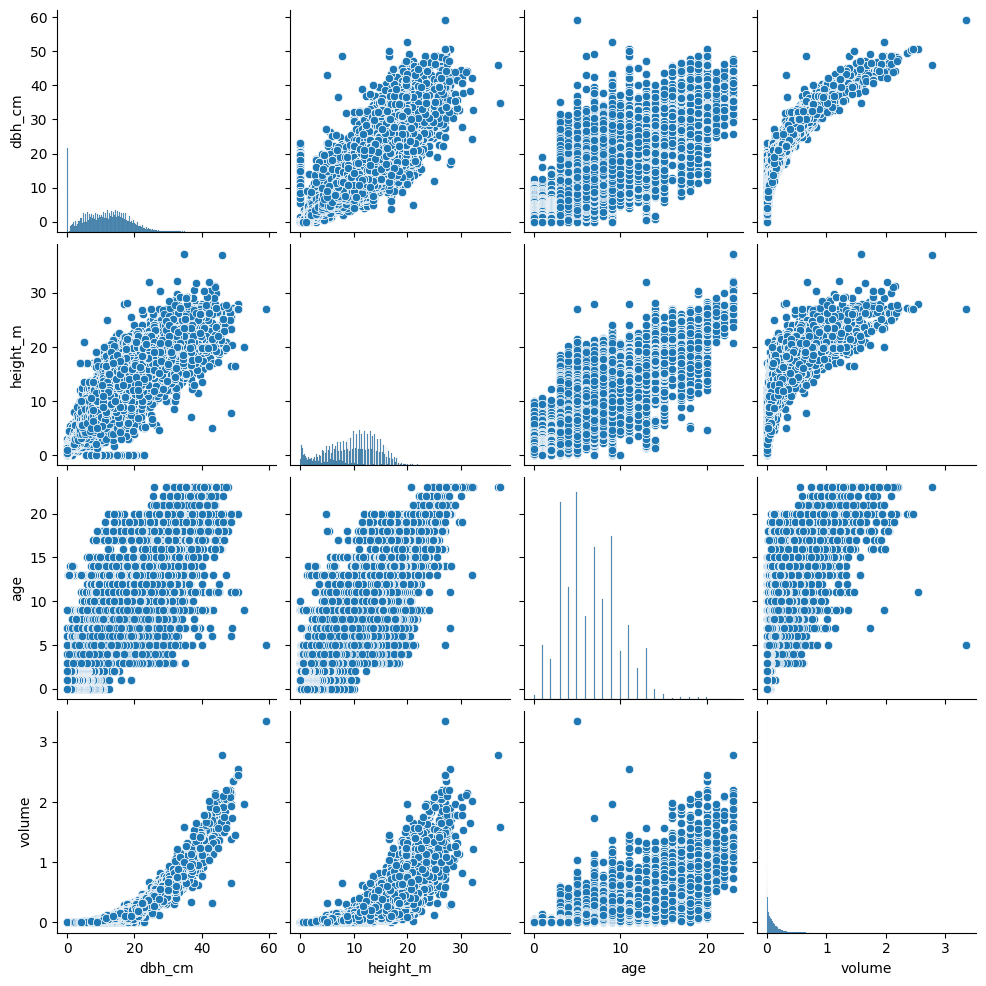

In [62]:
import seaborn as sns

sns.pairplot(df, vars=['dbh_cm', 'height_m', 'age', 'volume'])
plt.show()

In [63]:
df_encoded = pd.get_dummies(df, columns=['Thinning number'], drop_first=True)

In [64]:
df_encoded.head()

,Plantations,AreaType,Monitoring year,plot_id,tree_id,species,height_m,dbh_cm,REMARKS,Block,year_planted,productive_area,with_teak_ha,age,basal_area,volume,Thinning number_T2,Thinning number_T3,Thinning number_T4
0,Tain II,Teak,2018.0,1,71.0,Teak,7.25,12.0,Fire scars,B39,2013,61.114539,61.114539,5.0,0.011310,0.036898,False,False,False
1,Tain II,Teak,2018.0,1,71.0,Teak,7.25,12.0,Fire scars,B39,2013,61.114539,61.114539,5.0,0.011310,0.036898,True,False,False
2,Tain II,Teak,2018.0,1,76.0,Teak,8.25,12.0,Fire scars,B39,2013,61.114539,61.114539,5.0,0.011310,0.041987,False,False,False
3,Tain II,Teak,2018.0,1,76.0,Teak,8.25,12.0,Fire scars,B39,2013,61.114539,61.114539,5.0,0.011310,0.041987,True,False,False
4,Tain II,Teak,2018.0,1,68.0,Teak,7.00,11.8,Fire scars,B39,2013,61.114539,61.114539,5.0,0.010936,0.034448,False,False,False


In [65]:
from sklearn.model_selection import train_test_split

features = ['dbh_cm', 'height_m', 'age', 'Thinning number_T2', 'Thinning number_T3', 'Thinning number_T4']

X = df_encoded[features]
y = df_encoded['volume']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Linear Regression Model

In [66]:
from sklearn.linear_model import LinearRegression

model_lr = LinearRegression()
model_lr.fit(X_train, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


### Random Forest Model

In [67]:
from sklearn.ensemble import RandomForestRegressor
model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
model_rf.fit(X_train, y_train)

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


### XGBoost Model

In [68]:
from xgboost import XGBRegressor

model_xgb = XGBRegressor(n_estimators=100, random_state=42)
model_xgb.fit(X_train, y_train)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


### Models Evaluation

In [69]:
from sklearn.metrics import mean_squared_error, r2_score

for name, model in [('Linear', model_lr), ('RandomForest', model_rf), ('XGBoost', model_xgb)]:
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"{name}: MSE={mse:.2f}, R2={r2:.2f}")

Linear: MSE=0.00, R2=0.73
RandomForest: MSE=0.00, R2=1.00
XGBoost: MSE=0.00, R2=0.98


### Visualize Predictions Vs. Actual

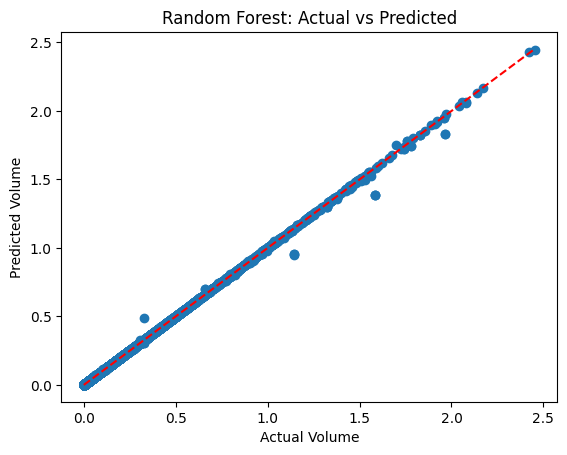

In [70]:
plt.scatter(y_test, model_rf.predict(X_test))
plt.xlabel('Actual Volume')
plt.ylabel('Predicted Volume')
plt.title('Random Forest: Actual vs Predicted')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.show()

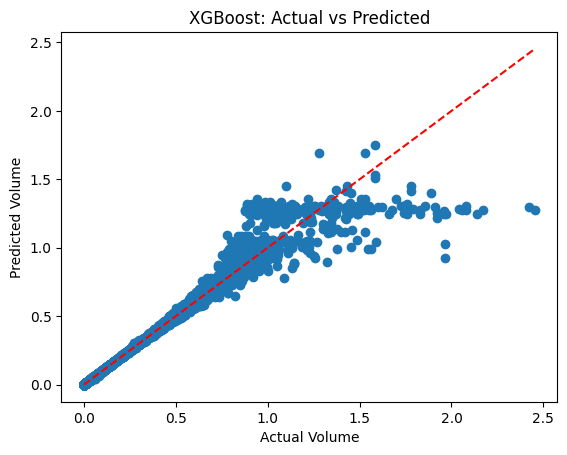

In [71]:
plt.scatter(y_test, model_xgb.predict(X_test))
plt.xlabel('Actual Volume')
plt.ylabel('Predicted Volume')
plt.title('XGBoost: Actual vs Predicted')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')

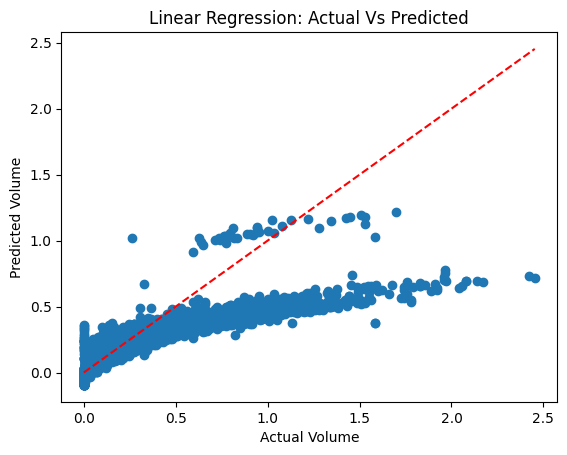

In [72]:
plt.scatter(y_test, model_lr.predict(X_test))
plt.xlabel('Actual Volume')
plt.ylabel('Predicted Volume')
plt.title('Linear Regression: Actual Vs Predicted')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.show()

### Feature Importance

In [73]:
importances = model_rf.feature_importances_

for feat, imp in zip(features, importances):
    print(f"{feat}: {imp:.2f}")

dbh_cm: 0.96
height_m: 0.04
age: 0.00
Thinning number_T2: 0.00
Thinning number_T3: 0.00
Thinning number_T4: 0.00


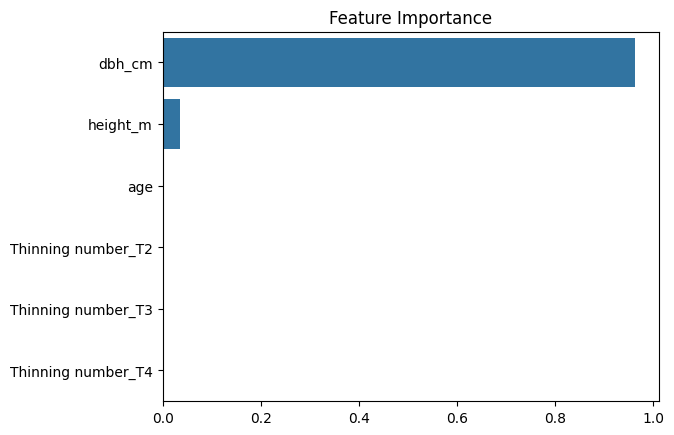

In [74]:
sns.barplot(x=importances, y=features)
plt.title('Feature Importance')
plt.show()

### Predict New Data

In [78]:
new_tree = pd.DataFrame({'dbh_cm': [30], 'height_m': [25], 'age': [15], 'Thinning number_T2': [True], 'Thinning number_T3': [True], 'Thinning number_T4': [False]})
predicted_volume = model_rf.predict(new_tree)
print(f"Predicted volume: {predicted_volume[0]:.2f} m3")

Predicted volume: 0.79 m3
